In [1]:
import numpy as np
import tensorflow as tf
import time
from matplotlib import pyplot as plt

from cleverhans.utils_tf import batch_eval

from utils_config import ModelConfig
from utils_experiment import get_data_dict, train_model
from utils_attacks import get_deltas
from dknn import DkNNModel

In [2]:
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
mc = ModelConfig(config_file='../configs/config_mnist.yaml',
                 root_dir='../results/')

In [ ]:
#train_model(mc)

In [5]:
data_dict = get_data_dict(mc)

# parse data_dict
x_train = data_dict['x_train'] 
labels_train = data_dict['labels_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']
x_cali = data_dict['x_cali'] 
labels_cali = data_dict['labels_cali']

In [6]:
means = np.array([np.mean(x_train[np.where(labels_train == i)], axis=0) for i in range(10)])
labels = np.arange(10)

In [ ]:
#N = 4000
#points = np.random.choice(x_train.shape[0], N) # to be used for the attack

In [7]:
# Use Image Parameters.
img_rows, img_cols, nchannels = x_train.shape[1:4]

with mc.get_tensorflow_session() as sess:
    with tf.variable_scope('dknn'):
        model_dir = mc.get_model_dir_name()
        model = mc.load_model(model_dir=model_dir)
        
        # Extract representations for the training and calibration data at each layer of interest to the DkNN.
        layers = ['ReLU1', 'ReLU3', 'ReLU5', 'logits']

        dknn = DkNNModel(
            sess = sess,
            model = model,
            neighbors = mc.nb_neighbors,
            proto_neighbors = mc.nb_proto_neighbors,
            img_rows=mc.img_rows,
            img_cols=mc.img_cols,
            nchannels=mc.nchannels,
            nb_classes=mc.nb_classes,
            layers=layers,
            train_data=x_train,
            train_labels=labels_train,
            method='euclidean',
            neighbors_table_path=mc.get_model_dir_name(),
            scope='dknn')
        start = time.time()
        dknn.fit()
        end = time.time()
        print('dknn time', end-start)
        dknn.calibrate(x_cali, labels_cali)
        preds_knn, _, _ = dknn.predict(x_test)
        print((preds_knn==np.argmax(y_test,axis=1)).mean())

################ Attack #####################################
        def wrapper_dknn(x):
            return dknn.predict(np.array([x]))
        
        deltas_k, norms_k = get_deltas(x_train,
                                       labels_train,
                                       means,
                                       labels,
                                       wrapper_dknn,
                                       eps=1e-2)
#############################################################
        
        dknn_geod = DkNNModel(
            sess = sess,
            model = model,
            neighbors = mc.nb_neighbors,
            proto_neighbors = mc.nb_proto_neighbors,
            img_rows=mc.img_rows,
            img_cols=mc.img_cols,
            nchannels=mc.nchannels,
            nb_classes=mc.nb_classes,
            layers=layers,
            train_data=x_train,
            train_labels=labels_train,
            method='geodesic',
            neighbors_table_path=mc.get_model_dir_name(),
            scope='dknn')
        start = time.time()
        dknn_geod.fit()
        end = time.time()
        print('gdknn time', end-start)
        dknn_geod.calibrate(x_cali, labels_cali)
        preds_geod, _, _ = dknn_geod.predict(x_test)
        print((preds_geod==np.argmax(y_test,axis=1)).mean())

##################### Attack ################################
        def wrapper_geod(x):
            return dknn_geod.predict(np.array([x]))
        
        deltas_g, norms_g = get_deltas(x_train,
                                       labels_train,
                                       means,
                                       labels,
                                       wrapper_geod,
                                       eps=1e-2)
############################################################# 

Loading model from:
 ../results/MNIST/nb_train_10000_lr_0.001_bs_2_1/model.joblib

Constructing the NearestNeighbor table layer ReLU1
Constructing the NearestNeighbor table layer ReLU3
Constructing the NearestNeighbor table layer ReLU5
Constructing the NearestNeighbor table layer logits
dknn time 192.87483739852905
Starting calibration.
Completed calibration.



  0%|          | 0/10000 [00:00<?, ?it/s]

0.9672


100%|██████████| 10000/10000 [49:58<00:00,  3.33it/s]


Constructing the GeodesicNearestNeighbor table layer ReLU1
Constructing the GeodesicNearestNeighbor table layer ReLU3
Constructing the GeodesicNearestNeighbor table layer ReLU5
Constructing the GeodesicNearestNeighbor table layer logits
gdknn time 256.6512632369995
Starting calibration.
Completed calibration.



  0%|          | 0/10000 [00:00<?, ?it/s]

0.9648


100%|██████████| 10000/10000 [53:12<00:00,  3.13it/s]


In [20]:
def cumulative_plot(xlist, label=None, bins=40, reverse=True):
    values, base = np.histogram(xlist, bins=bins)
    cumulative = np.cumsum(values)
    #plt.xscale('log')
    plt.plot(base[:-1], (len(xlist) - cumulative)/xlist.shape[0], label=label)

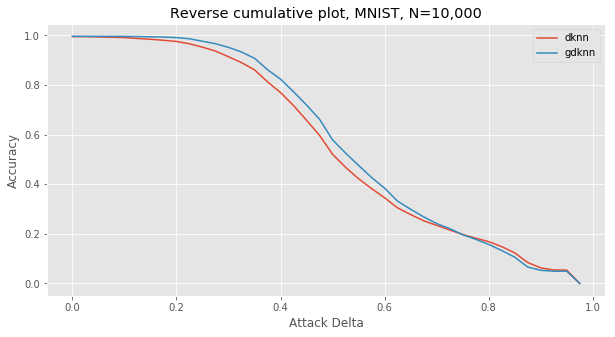

In [21]:
plt.style.use('ggplot')
cumulative_plot(deltas_k, label='dknn')
cumulative_plot(deltas_g, label='gdknn')
plt.title('Reverse cumulative plot, MNIST, N=10,000')
plt.xlabel('Attack Delta')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../results/attacks/deltas.png')
plt.show()

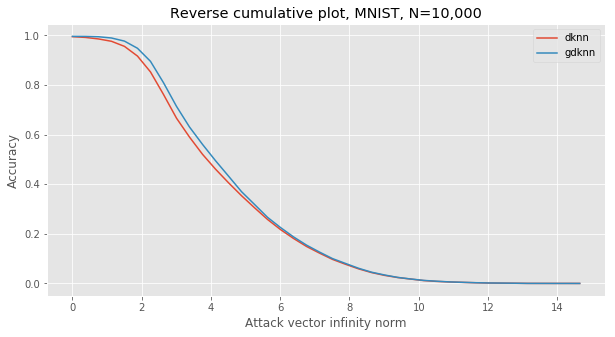

In [22]:
cumulative_plot(norms_k, label='dknn')
cumulative_plot(norms_g, label='gdknn')
plt.title('Reverse cumulative plot, MNIST, N=10,000')
plt.xlabel('Attack vector infinity norm')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../results/attacks/norms.png')
plt.show()

In [4]:
path = "../results/attacks/deltas_norms.pkl"

In [19]:
# Save
import pandas as pd
df = pd.DataFrame({"deltas_k": [deltas_k],
                   "deltas_g": [deltas_g],
                   "norms_k": [norms_k],
                   "norms_g": [norms_g]})
df.to_pickle(path)

In [5]:
# Load
import pandas as pd
df = pd.read_pickle(path)
deltas_k = df["deltas_k"][0]
deltas_g = df["deltas_g"][0]
norms_k = df["norms_k"][0]
norms_g = df["norms_g"][0]